# MATH-253 Hw 5 
# Grace Yang
# gy654



## Problem 1
Prove that the secant condition holds for the following two formulas:

1. $$B_{k+1} = B_k + \frac{(y_k-B_ks_k)v^T}{v^Ts_k}$$
assuming $$v^Ts_k \neq 0$$
2. The BFGS update


1. 
$$B_{k+1}s_k = (B_k + \frac{(y_k-B_ks_k)v^T}{v^Ts_k})s_k = B_ks_k + y_k - B_ks_k = y_k$$
therefore the secant condition holds

1. 
BFGS:
$$B_{k+1} = B_{k} - \frac{(B_ks_k)(B_ks_k)^T}{s_k^TB_ks_k} + \frac{y_ky_k^T}{y_k^Ts_k}$$
$$B_{k+1}s_k = (B_k - \frac{B_ks_k(B_ks_k)^T}{sk_TB_ks_k} +\frac{y_ky_k^T}{y_k^Ts_k}) s_k = B_ks_k - \frac{(B_ks_k)(B_ks_k)^T}{s_k^TB_k} + y_k = B_ks_k - \frac{B_ks_ks_k^TB_k^T}{s_k^TB_k} + y_k = y_k$$

therefore the secant condition holds


## Problem 2 (Lennard-Jones potential):
The Lennard-Jones potential is: 
$$V(r) = 4\epsilon[(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6]$$
The force due to this potential is just $F(r) = \frac{dV}{dr}$. If you plot $F$ (or do an image search), you will seet that there is net zero force if $r = \sigma$, a very string repelling force for $r<\sigma$, and a very weak attraction force if $ r > \sigma$. In this problem, we will explore doing a sumple molecular dynamics simulation in 2D using the Lennard-Jones potential. Consider a set of m particles in $R^m$ with positions given by $(x_i, y_i), i = 1, 2, ...m$. Let $r_{ij}$ be the distance between particles $i$ and $j$. The total potential energy for this system of particles is: 
$$f(x_1, y_1, ...x_m, y_m) = \sum_{i=1}^{m}\sum_{i \neq j}V(r_{ij})$$
Do the following: 
1. set $\sigma = \epsilon = 1$, and develop an algorithm for minimizing $f$ using $BFGS$

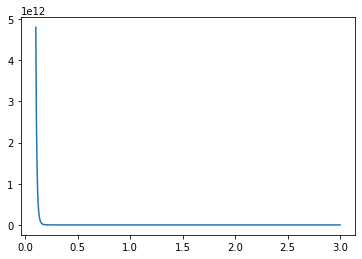

In [1]:
# First thing to do is to import numpy, matplotlib and colorcet

import numpy as np
import matplotlib.pyplot as plt
#import colorcet as cc 
from numpy.linalg import norm, inv
import warnings
warnings.filterwarnings("ignore")

def V(r):
    return 4 * ((1/r**12) - (1/r**6))

def F(r):
    return 48 * (1/np.power(r, 11)) - 24 * (1/np.power(r, 5))
r = np.linspace(0.1, 3, 1000)
plt.plot(r, F(r))



- Gradient
$$\frac{\partial f}{\partial x_i} = 8 \sum_{j=1, j \neq i}^{m}(-6r_{ij}^{-14} + 3 r_{ij}^{-8})(x_i-x_j)$$
$$\frac{\partial f}{\partial y_i} = 8 \sum_{j=1, j \neq i}^{m}(-6r_{ij}^{-14} + 3 r_{ij}^{-8})(y_i-y_j)$$

- Hessian
$$\frac{\partial f}{\partial x_ix_j} = -8[-6r_{ij}^{-14} +3 r_{ij}^{-8} + (84 r_{ij}^{-16} - 24 r_{ij}^{-10})(x_i-x_j)^2]$$
$$\frac{\partial f}{\partial y_iy_j} = -8[-6r_{ij}^{-14} +3 r_{ij}^{-8} + (84 r_{ij}^{-16} - 24 r_{ij}^{-10})(y_i-y_j)^2]$$

$$\frac{\partial f}{\partial x_iy_j} = \frac{\partial f}{\partial y_jx_i} = -8 (84 r_{ij}^{-16} - 24 r_{ij}^{-10})(x_i-x_j)(y_i-y_j)$$

In [2]:

def gradient_f(XY, m):
    X, Y = XY[:m], XY[m:]
    points = np.vstack((X, Y)).T
    gradient_X = []
    gradient_Y = []
    for i in range(len(X)):
        sum_i_x , sum_i_y = 0, 0
        for j in range(len(X)):
            if j == i:
                continue
            else:
                r = norm(points[i]-points[j])
                coef = -48 * (1/r**14) + 24 * (1/r**8)
                sum_i_x += coef *(X[i] - X[j])
                sum_i_y += coef *(Y[i] - Y[j])
        gradient_X.append(sum_i_x/2)
        gradient_Y.append(sum_i_y/2)

    return np.array(gradient_X + gradient_Y)

In [93]:
def generate_points(M):
    #X = np.random.uniform(-2, 2, M)
    #Y = np.random.uniform(-2, 2, M)
    X = np.random.normal(scale = 2.5, size = M)
    Y = np.random.normal(scale = 2.5, size = M)
    #X = np.linspace(0, 2*M, M)
    #Y = np.linspace(0, 2*M, M)
    return list(X) + list(Y)


def V(r):
    return 4 * ((1/r**12) - (1/r**6))

def potential_energy(XY, m):
    X, Y = XY[:m], XY[m:]
    points = np.vstack((X, Y)).T
    sum = 0
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            r_ij = norm(points[i]-points[j])
            sum += V(r_ij)
    return sum



def backTr(alpha, XYn, direction, m):
    '''
    Backtracking algorithm
    '''
    Fn = potential_energy(XYn, m) # Function value of previous iteration
    XYn_1 = XYn + alpha * direction # possible update for x
    Fn_1 = potential_energy(XYn_1, m)
    beta = 0.8
    while Fn < Fn_1:
        # while we don't have a decrease in the function value
        alpha = alpha * beta
        XYn_1 = XYn + alpha * direction
        Fn_1 = potential_energy(XYn_1, m) # Try again
    return alpha

def steepDesc_Ros(XY0, tol, maxIter, m):
    '''
    Function that minimizes the Rosenbrock function
    in free space using the steepest descent direction
    '''
    XYn = XY0
    XYn_vec = [XYn]
    F_vec = [potential_energy(XYn, m)]
    i = 0
    d = - gradient_f(XYn, m)
    while( norm(d) >= tol and i < maxIter ):
        d = -gradient_f(XYn, m)
        alpha0= 2/m
        alpha = backTr(alpha0, XYn, d, m)
        XYn = XYn + alpha * d
        XYn_vec.append(XYn)
        F_vec.append(potential_energy(XYn, m))
        i += 1
    return XYn, XYn_vec, F_vec, i
    
def bfgs(XY0, H0_X, m, tol, alpha0, maxIter):
    XYn = XY0
    XYn_vec = [XYn]
    Hk_X = H0_X
    F_vec = [potential_energy(XYn, m)]
    I = np.identity(int(len(XYn))) # we need this to use the formula
    Hk = I
    i = 0
    g = gradient_f(XYn, m)
    rho_inv = 1
    while (((norm(g)>=tol)  & (i<maxIter) & (abs(1/rho_inv)>=tol) ).all()):
        d = -Hk @ g
        alpha = backTr(alpha0, XYn, d, m)
        XYn = XYn + alpha * d
        XYn_vec.append(XYn)
        F_vec.append(potential_energy(XYn, m))
        gnew = gradient_f(XYn, m)
        sk = alpha * d # debate last week
        yk = gnew-g
        rho_inv = yk.T @ sk
        Hk = (I - 1/rho_inv * sk @yk.T) @Hk_X@(I - 1/rho_inv * yk.T @sk) + 1/rho_inv *sk@sk.T
        i +=1
        g = gnew
        if abs(F_vec[-1] -F_vec[-2])<tol:
            break
    return XYn, XYn_vec, F_vec, i

def unpack_config(XY, m):
    X, Y = XY[:m], XY[m:]
    return X, Y
   
def plot_XY(X, Y, color, M):
    plt.axis('equal')
    plt.scatter(X, Y, color = color)
    ax = plt.gca()
    for x, y in list(zip(X, Y)):
        circle = plt.Circle((x,y),1, color = color, fill = False)
        ax.add_artist(circle)
    plt.title(f'M = {M}')
    plt.show()

def GD_potential(M, color):
    maxIter = 1000
    tol = 1e-8
    XY0 = generate_points(M)
    H0 = np.identity(2*M)
    XYn, XYn_vec, F_vec, i = steepDesc_Ros(XY0, tol, maxIter, M)
    Xn, Yn = unpack_config(XYn, M)
    plot_XY(Xn, Yn, color, M)
    print(f'----------Experiment M={M} begins--------------------')
    print(f'config found with BFGS: Xn: {Xn},Yn: {Yn}')
    print('Optimal with Bfgs: ', potential_energy(XYn, M), '\n')
    #print(f'F_vec:{F_vec}')
    print('Numebr of iterations: ', i)
    print(f'----------Experiment M={M} ends----------------------')
    return Xn, Yn, XYn_vec, F_vec, i
#M = 3
#Xn, Yn, XYn_vec, F_vec, i = GD_potential(M, 'blue')


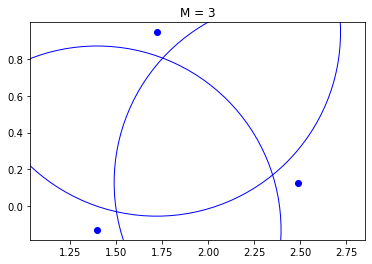

----------Experiment M=3 begins--------------------
config found with BFGS: Xn: [2.48941888 1.72029183 1.39688007],Yn: [ 0.12837862  0.94587806 -0.12895523]
Optimal with Bfgs:  -2.9999999401980006 

Numebr of iterations:  184
----------Experiment M=3 ends----------------------


In [94]:

def BFGS_potential(M, color):
    maxIter = 1000
    alpha0 = 1
    tol = 1e-8
    XY0 = generate_points(M)
    H0 = np.identity(2*M)
    XYn, XYn_vec, F_vec, i = bfgs(XY0, H0, M, tol, alpha0, maxIter)
    Xn, Yn = unpack_config(XYn, M)
    plot_XY(Xn, Yn, color, M)
    print(f'----------Experiment M={M} begins--------------------')
    print(f'config found with BFGS: Xn: {Xn},Yn: {Yn}')
    print('Optimal with Bfgs: ', potential_energy(XYn, M), '\n')
    #print(f'F_vec:{F_vec}')
    print('Numebr of iterations: ', i)
    print(f'----------Experiment M={M} ends----------------------')
    return Xn, Yn, XYn_vec, F_vec, i
M = 3
Xn, Yn, XYn_vec, F_vec, i = BFGS_potential(M, 'blue')

2. Apply this algorithm to systems with m = 3, 4, ...10 particles and visualize your results:
- Make sure to initialize randomly, and note that if your particles are too far apart initially, it will take a while to reach a local minimum because of the weak attractive force. On the other hand, because of the strong repelling forces, it is important to use a backtracking line search
- Plot your local minimizers by using a scatter plot for the positions of $(x_i, y_i)$. Additionally, draw a circle of radius $\sigma = 1$ surrounding each particle. It may also help to plot each dot/circle pair using a different color
- Threre are numerous local minimizers for this system. See how many you can find. 

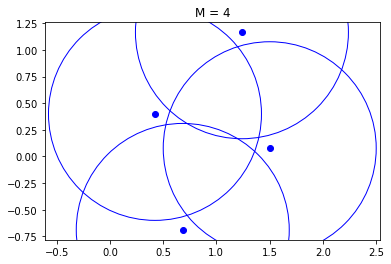

----------Experiment M=4 begins--------------------
config found with BFGS: Xn: [1.23999702 0.42346942 1.50097211 0.68433584],Yn: [ 1.1663907   0.39972961  0.07718065 -0.68984348]
Optimal with Bfgs:  -5.073417478465943 

Numebr of iterations:  769
----------Experiment M=4 ends----------------------


769

In [54]:
BFGS_potential(4, 'blue')

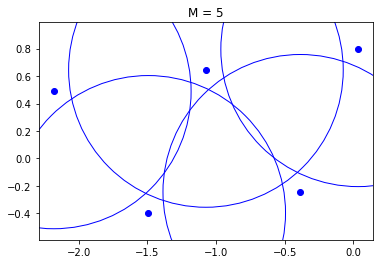

----------Experiment M=5 begins--------------------
config found with BFGS: Xn: [-0.38620372 -2.18134319 -1.49371792  0.03523466 -1.07341136],Yn: [-0.24263992  0.48836507 -0.3960066   0.79524773  0.6448469 ]
Optimal with Bfgs:  -7.178023386230088 

Numebr of iterations:  370
----------Experiment M=5 ends----------------------


In [124]:
Xn, Yn, XYn_vec, F_vec, i = BFGS_potential(5, 'blue')

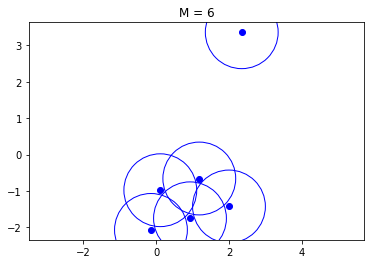

----------Experiment M=6 begins--------------------
config found with BFGS: Xn: [ 0.11168847  1.18248298  1.99783922  2.34845218 -0.14523535  0.92708968],Yn: [-0.97903081 -0.65726825 -1.42550076  3.36024472 -2.06935584 -1.75036219]
Optimal with Bfgs:  -7.179659762063375 

Numebr of iterations:  206
----------Experiment M=6 ends----------------------


In [128]:
Xn, Yn, XYn_vec, F_vec, i = BFGS_potential(6, 'blue')

In [115]:

from sympy import *
from scipy.optimize import minimize
def problem2(m, color):
    def fn_subs(fn,x,value):
        subs_dict = dict(zip(x, value))
        return fn.subs(subs_dict)

    x = [Symbol('x_'+str(i)) for i in range(m)]
    y = [Symbol('y_'+str(i)) for i in range(m)]
    cost_fn = 0
    for i in range(m):
        for j in range(m):
            if i!=j:
                a = (x[j]-x[i])**2+(y[j]-y[i])**2
                cost_fn += 4*(a**(-6)-a**(-3))
        
    gradient = derive_by_array(cost_fn, x+y)

    def grad_eval_wrapper(variables): 
        return np.array(grad_eval(*list(variables)))

    cost_eval = lambdify(x+y,cost_fn) 

    def cost_eval_wrapper(variables): 
        return cost_eval(*list(variables))
    grad_eval = lambdify(x+y,gradient)  

    eps=1e-8
    scale =2.5
    coordinates_1= tuple(np.random.normal(scale=scale, size=m))
    coordinates_2 = tuple(np.random.normal(scale=scale, size=m))
    initial_config_x,initial_config_y=coordinates_1,coordinates_2
    configuration  = initial_config_x+initial_config_y

    res = minimize(cost_eval_wrapper, x0=np.array(configuration), method='L-BFGS-B', jac=grad_eval_wrapper,options={'gtol': 1e-6, 'disp': True})

    final_configuration = tuple(res.x)
    xs,ys=final_configuration[0:m],final_configuration[m:]

    _x,_y =np.array(xs).mean(),np.array(xs).mean()
    xs = np.array(xs)-_x
    ys = np.array(ys)-_y

    plot_XY(xs, ys, color, m)


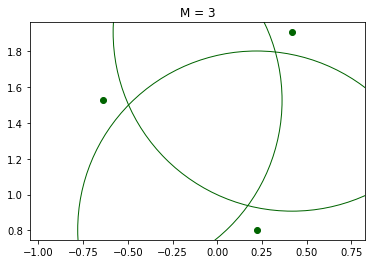

In [117]:
problem2(3, 'darkgreen')

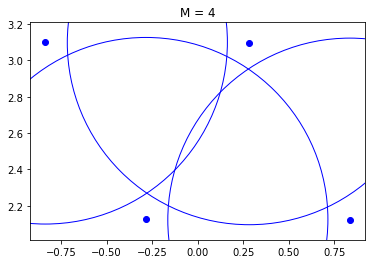

In [95]:
problem2(4, 'blue')

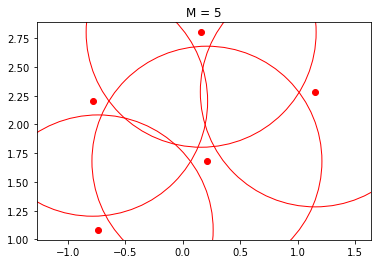

In [98]:
problem2(5, 'red')

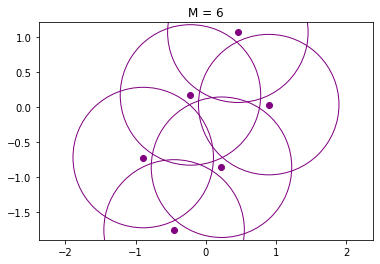

In [100]:
problem2(6, 'purple')

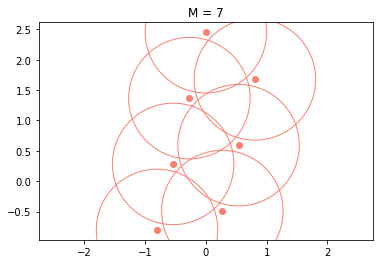

In [101]:
problem2(7, 'salmon')

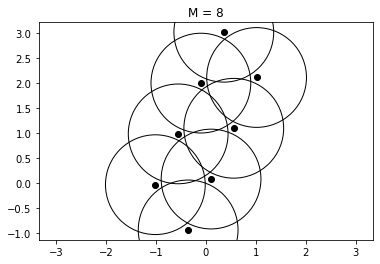

In [102]:
problem2(8, 'black')

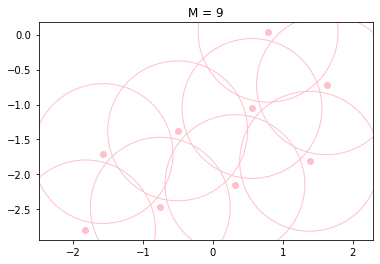

In [104]:
problem2(9, 'pink')

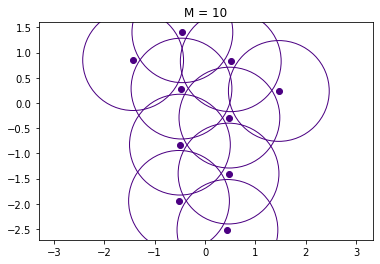

In [105]:
problem2(10, 'indigo')

## See how many local minima we can find for m = 3

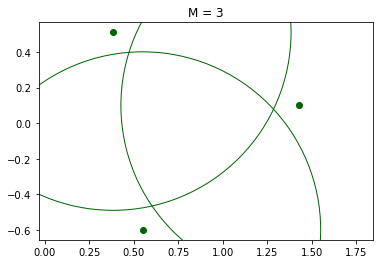

----------Experiment M=3 begins--------------------
config found with BFGS: Xn: [0.38355047 1.42806225 0.54993851],Yn: [ 0.51042346  0.09950266 -0.59961068]
Optimal with Bfgs:  -2.999999938181352 

Numebr of iterations:  599
----------Experiment M=3 ends----------------------


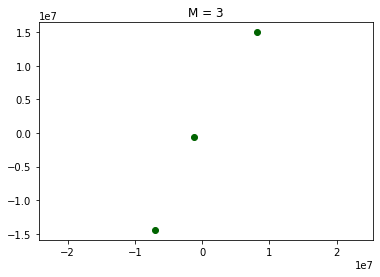

----------Experiment M=3 begins--------------------
config found with BFGS: Xn: [ 8095731.65395387 -6943309.61015999 -1152425.96839672],Yn: [ 14984205.65986216 -14421766.52443273   -562444.35523802]
Optimal with Bfgs:  -4.655425608209791e-43 

Numebr of iterations:  1
----------Experiment M=3 ends----------------------


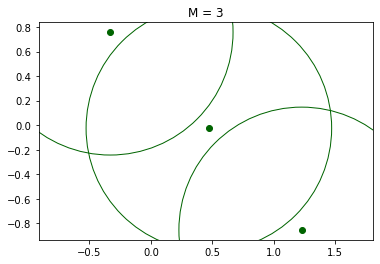

----------Experiment M=3 begins--------------------
config found with BFGS: Xn: [ 0.47222301  1.22821073 -0.33091904],Yn: [-0.02486013 -0.85278984  0.75705366]
Optimal with Bfgs:  -2.031203653007867 

Numebr of iterations:  757
----------Experiment M=3 ends----------------------


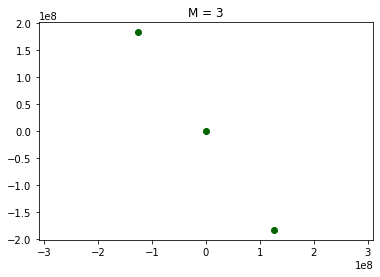

----------Experiment M=3 begins--------------------
config found with BFGS: Xn: [-1.81320608e+02  1.26109303e+08 -1.26109120e+08],Yn: [ 4.35288895e+02 -1.83341377e+08  1.83340940e+08]
Optimal with Bfgs:  -6.6403846685465e-50 

Numebr of iterations:  1
----------Experiment M=3 ends----------------------


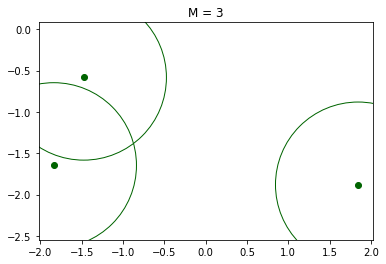

----------Experiment M=3 begins--------------------
config found with BFGS: Xn: [ 1.84505604 -1.47413405 -1.83652198],Yn: [-1.87973242 -0.5825264  -1.64578873]
Optimal with Bfgs:  -1.003517383442918 

Numebr of iterations:  27
----------Experiment M=3 ends----------------------


[-3.0, -0.0, -2.03, -1.0]

In [16]:
min_list = []
for i in range(5):
    color_l = ['darkgreen', 'darkblue', 'slateblue', 'darkred', 'chocolate', 'salmon', 'indigo', 'darkslategray']
    color_iter = iter(color_l)
    Xn, Yn, XYn_vec, F_vec, i = BFGS_potential(3, next(color_iter))
    if  float(f'{F_vec[-1]:.2f}') not in min_list:
        min_list.append(float(f'{F_vec[-1]:.2f}'))
min_list

When M is small, the BFGS converges to points that form symmetric geometry in the xy plane. When M is large, the BFGS converges to points with extreme xy coordinates. 

## Problem3 (Fermat's principle)
Consider a particle traveling with speed c(x, y) meters per second. If we assume that the particle travels between two points $r_0$ and $r_1$ following the minimum travel time trajectory $r(t)$, where $r(0) = r_0, r(1)= r_1$, then $r:[0, 1] \to R^2$ can be found by minimizing:
 $$ F[r] = \int_0^1\frac{||r'(t)||}{c(r(t))}dt$$ 
This is a minimization problem where the variable being minimized over is a function instead of a vector. One approach to solve this problem is to use the calculus of variations, which is outside the scope of this class. Anoher approach is to approximate the integral in 3 using a quadrature rule and then solve the resulting finite-dimensional minimization problem.

Consider solving this problem for $(x, y) \in \omega = [0,1] \times [0,1]$, where the particle speed is: 
$$c(x, y) = 1+ \sqrt{4-3x-y}$$
One simple but useful quadrature rule is the composite trapezoid:

$$\int_a^b f(t)dt = \sum_{i=1}^{m} \frac{f(t_{i-1})+f(t_i)}{2} \Delta t_i + O(\underset{1 \leq i \leq m} {max} \Delta t_i^{2})$$ 

where $a = t_0 < t1<...<t_m = b$ , and where $\Delta t_i = t_i - t_{i-1}>0$

1. Use the composite trapezoid rule to approximate the integral for an arbitrary number of points (m+1 points as above). To keep things simple, use uniform spacing i.e. choose the $t_i$'s such that $\Delta t_i = h$ for all $i$. Denote your cost function by $f(t_0, t_1, ...t_m)$ and write down the new finite_dimensional minimization problem to solve. Compute the gradient of $\nabla f(t_0, ...t_m)$

New problem: minimize $f(t_0, t_1, ...t_m)$

$$f(x_0, ...x_m, y_0, ...y_m) = \frac{1}{2} [((x_{1}-x_{0})^2 + (y_{1}-y_{0})^2)^{\frac{1}{2}}(4-3x_0-y_0)^{\frac{1}{2}} + ((x_{m}-x_{m-1})^2 + (y_{m}-y_{m-1})^2)^{\frac{1}{2}}(4-3x_m-y_m)^{\frac{1}{2}}] + \sum_{t=2}^{m-1}((x_{t}-x_{t-1})^2 + (y_{t}-y_{t-1})^2)^{\frac{1}{2}}(4-3x_t-y_t)^{\frac{1}{2}} $$
when $2\leq t<m$
$$\frac{\partial f}{\partial x_t} = \frac{1}{2} ((x_{t}-x_{t-1})^2 + (y_{t}-y_{t-1})^2)^{-\frac{1}{2}} \cdot 2(x_{t}-x_{t-1})(4-3x_t-y_t)^{\frac{1}{2}} + ((x_{t+1}-x_{t})^2 + (y_{t+1} - y_{t})^2)^{\frac{1}{2}} \frac{1}{2}(4-3x_t-y_t)^{-\frac{1}{2}}(-3)  $$
$$= ((x_{t}-x_{t-1})^2 + (y_{t}-y_{t-1})^2)^{-\frac{1}{2}} (x_{t}-x_{t-1})(4-3x_t-y_t)^{\frac{1}{2}} -\frac{3}{2} ((x_{t+1}-x_{t})^2 + (y_{t+1} - y_{t})^2)^{\frac{1}{2}} (4-3x_t-y_t)^{-\frac{1}{2}} + ((x_{t+1}-x_{t})^2 + (y_{t+1}-y_{t})^2)^{-\frac{1}{2}} (x_{t}-x_{t+1})(4-3x_t-y_t)^{\frac{1}{2}} $$

Similarly: 
$$\frac{\partial f}{\partial y_t} = \frac{1}{2} ((x_{t}-x_{t-1})^2 + (y_{t}-y_{t-1})^2)^{-\frac{1}{2}} \cdot 2(y_{t}-y_{t-1})(4-3x_t-y_t)^{\frac{1}{2}} + ((x_{t+1}-x_{t})^2 + (y_{t+1} - y_{t})^2)^{\frac{1}{2}} \frac{1}{2}(4-3x_t-y_t)^{-\frac{1}{2}}(-1)  $$
$$= ((x_{t}-x_{t-1})^2 + (y_{t}-y_{t-1})^2)^{-\frac{1}{2}} (x_{t}-x_{t-1})(4-3x_t-y_t)^{\frac{1}{2}} -\frac{1}{2} ((x_{t+1}-x_{t})^2 + (y_{t+1} - y_{t})^2)^{\frac{1}{2}} (4-3x_t-y_t)^{-\frac{1}{2}} + ((x_{t+1}-x_{t})^2 + (y_{t+1}-y_{t})^2)^{-\frac{1}{2}} (x_{t}-x_{t+1})(4-3x_t-y_t)^{\frac{1}{2}} $$


Therefore, the cost function we need to minimize can be written as:

$$\int_{0}^{1}\frac{||r'(t)||dt}{c(r)} = \sum_{i=0}^{m-1}\frac{2}{m}(\sqrt{4-3x_i-y_i} + \sqrt{4-3x_{i+1}-y_{i+1}}) \sqrt{(x_i-x_{i+1})^2+(y_i-y_{i+1})^2}$$

In [37]:
from sympy import *
import numpy as np
#import colorcet as cc 
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


def fn_subs(fn,x,value):
    subs_dict = dict(zip(x, value))
    return fn.subs(subs_dict)

def cost_function(m, x_start, y_start, x_end, y_end):
    x = [Symbol('x_'+str(i)) for i in range(m+2)]
    y = [Symbol('y_'+str(i)) for i in range(m+2)]
    cost_fn = 0.5 * ((x[1]-x[0])**2+(y[1]-y[0])**2)**0.5*(4-3*x[0]-y[0])**0.5 + 0.5 * ((x[m+1]-x[m])**2+(y[m+1]-y[m])**2)**0.5*(4-3*x[m+1]-y[m])**0.5

    for i in range(1, m):
        cost_fn += ((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)**0.5*(4-3*x[i]-y[i])**0.5
    cost_fn = fn_subs(cost_fn,(x[0],y[0],x[m+1],y[m+1]),(x_start,y_start,x_end,y_end))
    x,y = x[1:m+1],y[1:m+1]
    # Now, x & y are lists of (m-1) elements which are X & Y coordinates of (m-1) positions that particle travels through
    # Calculate gradient of cost function w.r.t X & Y coordinates in symbolic form
    gradient = derive_by_array(cost_fn, x+y)
    hessian = derive_by_array(gradient, x+y)

    # Generate python functions out of symbolic expressions so that evaluation of cost function and its gradient will be more efficient
    cost_eval = lambdify(x+y,cost_fn) 
    grad_eval = lambdify(x+y,gradient) 
    hessian_eval = lambdify(x+y, hessian)
    return cost_eval, grad_eval, hessian_eval, cost_fn



def initialize(m):

    # Intial configuration is on the line from start position to end position
    #coordinates = tuple(np.linspace(0,1, num=m+1)[1:-1])
    # Random initialization
    coordinates_1 = tuple(np.sort(np.random.uniform(low=0, high=0.8,size=m)))
    #coordinates_1 = tuple(np.random.uniform(low=0, high=1,size=m-1))
    coordinates_2 = tuple(np.random.uniform(low=0, high=0.8,size=m))
    initial_config_x,initial_config_y=coordinates_1,coordinates_2
    configuration  = initial_config_x+initial_config_y
    return configuration





def fetch_config(configuration_lists, index, m):
    return configuration_lists[index][0:m], configuration_lists[index][m:]
import matplotlib.pyplot as plt


def c(x, y):
    return 1+ np.sqrt(4-3*x-y)


def plot_traj(xs, ys, m):
    # Start plotting
    Nx = 100 # number of points in the x axis
    Ny = 100 # number of points in the y axis

    # Plot on bigger square
    x, y = np.meshgrid( np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))
    z = c(x, y)

    plt.figure(figsize = (5, 5) )
    im1 = plt.contourf(x, y, z, levels = 50, cmap = 'BuPu_r' )
    plt.scatter(xs, ys)
    plt.title(f'm = {m}')
    plt.axis('equal')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.colorbar(im1)
    plt.show(block = False)




In [48]:


def gradient_descent(m):
    print(f'----------------Experiment Gradient Descent for m={m} starts!----------')
    alpha =.05
    beta =.9
    maxIter = 1000
    eps = 1e-4
    x_start = 0
    y_start = 0
    x_end = 1
    y_end = 1
    cost_eval, grad_eval,_ , _ = cost_function(m, x_start, y_start, x_end, y_end)
    configuration = initialize(m)
    fn_values =[]
    configuration_lists =[]
    prev_cost_value = cost_eval(*list(configuration))
    # Record initial configuration and cost function value
    fn_values.append(prev_cost_value)
    configuration_lists.append(configuration)
    lr= alpha 
    # signal : 1, continute iteration ; 0: stop iteration 
    signal =1
    # Iteration loop
    for i in range(maxIter):
        # If previous iteration attemp makes no progress ,then break out earlier!
        if signal == 0 : 
            break
        lr=alpha
        g_np_array= np.array(grad_eval(*list(configuration)))
        signal = 0
        for j in range(40):
            candidate_configuration = np.array(configuration) - lr*g_np_array
            # Projection to [0,1-eps]x[0,1-eps]
            # We introduce a small value of eps to prevent gradient calculation overflows
            candidate_configuration = np.maximum(0,np.minimum(1-eps,candidate_configuration))
            cost_value = cost_eval(*list(candidate_configuration))
            if cost_value < prev_cost_value :
                configuration = tuple(candidate_configuration)
                prev_cost_value = cost_value
                fn_values.append(prev_cost_value)
                configuration_lists.append(configuration)
                signal =1
                break
            lr *=beta

    xs,ys=fetch_config(configuration_lists,-1,m)
    xs = [x_start] + list(xs) + [x_end]
    ys = [y_start] + list(ys) + [y_end]
    plot_traj(xs, ys, m)
    print(f'----------------Experiment Gradient Descent for m={m} ends!----------')
    return fn_values, configuration_lists, i


----------------Experiment Gradient Descent for m=5 starts!----------


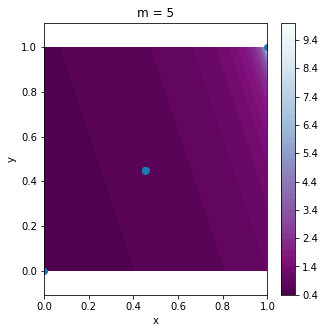

----------------Experiment Gradient Descent for m=5 ends!----------


In [49]:
fn_5_g, conf_5_g, i_5_g= gradient_descent(5)

----------------Experiment Gradient Descent for m=10 starts!----------


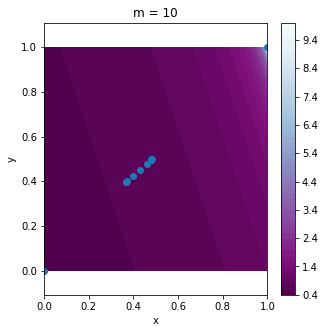

----------------Experiment Gradient Descent for m=10 ends!----------


In [50]:
fn_10_g, conf_10_g, i_10_g = gradient_descent(10)

----------------Experiment Gradient Descent for m=20 starts!----------


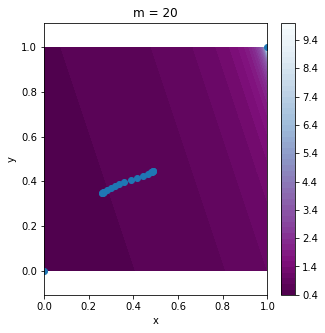

----------------Experiment Gradient Descent for m=20 ends!----------


In [51]:
fn_20_g, conf_20_g , i_20_g= gradient_descent(20)

----------------Experiment Gradient Descent for m=40 starts!----------


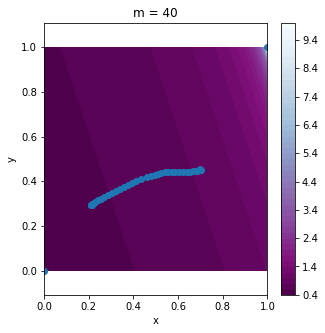

----------------Experiment Gradient Descent for m=40 ends!----------


In [52]:
fn_40_g, conf_40_g, i_40_g = gradient_descent(40)

----------------Experiment Gradient Descent for m=80 starts!----------


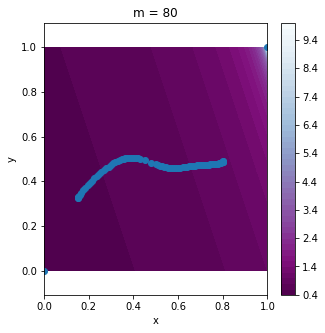

----------------Experiment Gradient Descent for m=80 ends!----------


In [53]:
fn_80_g, conf_80_g, i_80_g = gradient_descent(80)

----------------Experiment Gradient Descent for m=160 starts!----------


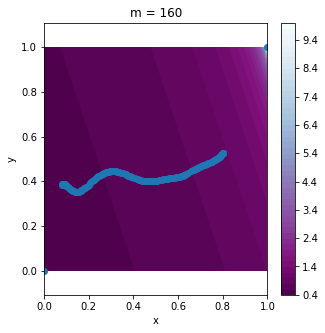

----------------Experiment Gradient Descent for m=160 ends!----------


In [54]:
fn_160_g, conf_160_g, i_160_g = gradient_descent(160)

In [55]:
from scipy.optimize import minimize, SR1

## SR1

In [79]:
def backTr(cost_eval, configuration,  sk):
    '''
    Backtracking algorithm for DIXAMAANA
    '''
    alpha = 0.8
    Fn = cost_eval(*list(configuration))
    xn = configuration
    xn_1 = xn + alpha*sk
    Fn_1 = cost_eval(*list(xn_1)) # function value of possible next iteration
    while Fn < Fn_1:
        alpha = alpha*beta
        xn_1 = xn + alpha*sk
        Fn_1 = cost_eval(*list(xn_1))  # Try again
    return alpha



def sr1_attempt(m):
    alpha =.1
    maxIter = 1000
    epsilon = 1e-4
    x_start = 0
    y_start = 0
    x_end = 1
    y_end = 1
    tol = 1e-12
    cost_eval, grad_eval, hessian_eval,_ = cost_function(m, x_start, y_start, x_end, y_end)
    configuration = initialize(m)
    prev_cost_value = cost_eval(*list(configuration))
    configuration_lists =[configuration]
    fn_values =[prev_cost_value]

    g = np.array(grad_eval(*list(configuration)))
    sk = np.ones(g.shape) # x(k+1) - x(k) = alpha * d
    B0 = np.array(hessian_eval(*list(configuration)))
    Bk = B0
    Hk = inv(Bk)
    Hk = np.identity(2* m)
    i = 0

    while (norm(g) >=tol and i< maxIter and norm(sk) >= tol):
        
        sk = - Hk @ g
        alpha = backTr( cost_eval, configuration,  sk)
        candidate_configuration = configuration + alpha * sk
        candidate_configuration = np.maximum(0,np.minimum(1-epsilon,candidate_configuration))
        gnew = np.array(grad_eval(*list(candidate_configuration))) 
        yk = gnew - g 
        frac = (sk - Hk@ yk).T @yk
        Hk = Hk + (1/frac)* (sk - Hk @yk) @(sk - Hk@ yk).T
        configuration_lists.append(candidate_configuration)
        cost_n = cost_eval(*list(candidate_configuration))
        fn_values.append(cost_n)
        g = gnew
        i +=1

    xs,ys=fetch_config(configuration_lists,-1,m)
    xs = [x_start] + list(xs) + [x_end]
    ys = [y_start] + list(ys) + [y_end]
    plot_traj(xs, ys, m)

In [ ]:
sr1_attempt(10)

## BFGS
$$B_{k+1} = B_k + \frac{y_ky_k^T}{y_k^T s_k} - \frac{B_k s_k s_k^T B_k}{s_k ^T B_k s_k}$$

In [80]:




def bfgs_attempt(m):
    alpha =.1
    maxIter = 1000
    epsilon = 1e-4
    x_start = 0
    y_start = 0
    x_end = 1
    y_end = 1
    tol = 1e-12
    cost_eval, grad_eval, hessian_eval,_ = cost_function(m, x_start, y_start, x_end, y_end)
    configuration = initialize(m)
    prev_cost_value = cost_eval(*list(configuration))
    configuration_lists =[configuration]
    fn_values =[prev_cost_value]

    g = np.array(grad_eval(*list(configuration)))
    sk = np.ones(g.shape) # x(k+1) - x(k) = alpha * d
    B0 = np.array(hessian_eval(*list(configuration)))
    Bk = B0
    Hk = inv(Bk)

    i = 0

    while (norm(g) >=tol and i< maxIter and norm(sk) >= tol):
        
        sk = - Hk @ g
        alpha = backTr( cost_eval, configuration,  sk)
        candidate_configuration = configuration + alpha * sk
        candidate_configuration = np.maximum(0,np.minimum(1-epsilon,candidate_configuration))
        gnew = np.array(grad_eval(*list(candidate_configuration))) 
        yk = gnew - g 
        Hk = Hk + np.outer((sk - Hk @ yk) , (sk - Hk @ yk) )/((sk-Hk@yk).T @yk)
        configuration_lists.append(candidate_configuration)
        cost_n = cost_eval(*list(candidate_configuration))
        fn_values.append(cost_n)
        g = gnew
        i +=1

    xs,ys=fetch_config(configuration_lists,-1,m)
    xs = [x_start] + list(xs) + [x_end]
    ys = [y_start] + list(ys) + [y_end]
    plot_traj(xs, ys, m)

-------------Experiment for m = 5 starts!--------------


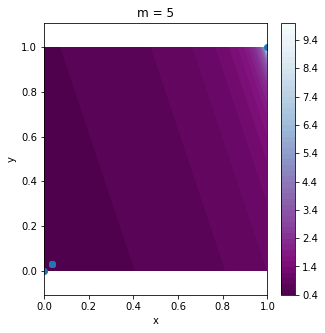

-------------Experiment for m = 5 ends!--------------


In [28]:

def bfgs(m):
    print(f'-------------Experiment for m = {m} starts!--------------')
    maxIter = 1000
    epsilon = 1e-4
    x_start = 0
    y_start = 0
    x_end = 1
    y_end = 1
    cost_eval, grad_eval, hessian_eval,_ = cost_function(m, x_start, y_start, x_end, y_end)

    cost_wrapper = lambda config: cost_eval(*list(config))
    configuration = initialize(m)
    res = minimize(cost_wrapper, x0 = np.array(configuration), method = 'L-BFGS-B', options={'gtol': 1e-05, 'eps': epsilon, 'maxiter': maxIter} )
    xs,ys=res.x[:m], res.x[m:]
    f_value = cost_eval(*list(res.x))
    xs = [x_start] + list(xs) + [x_end]
    ys = [y_start] + list(ys) + [y_end]
    plot_traj(xs, ys, m)
    print(f'-------------Experiment for m = {m} ends!--------------')
    return f_value, xs, ys, res
f_value_5, xs_5, ys_5, res_5 = bfgs(5)

-------------Experiment for m = 10 starts!--------------


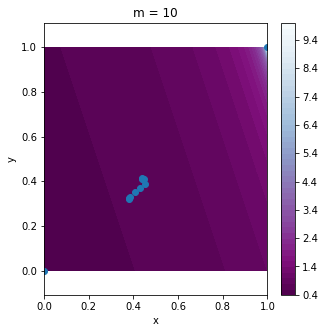

-------------Experiment for m = 10 ends!--------------


In [30]:
f_value_10, xs_10, ys_10, res_10 = bfgs(10)

-------------Experiment for m = 20 starts!--------------


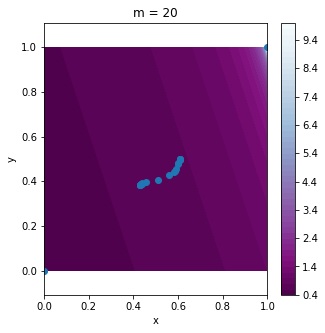

-------------Experiment for m = 20 ends!--------------


In [31]:
f_value_20, xs_20, ys_20, res_20 = bfgs(20)

-------------Experiment for m = 40 starts!--------------


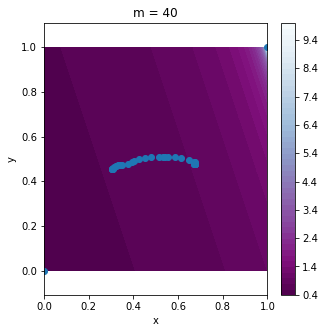

-------------Experiment for m = 40 ends!--------------


In [32]:
f_value_40, xs_40, ys_40, res_40 = bfgs(40)

-------------Experiment for m = 80 starts!--------------


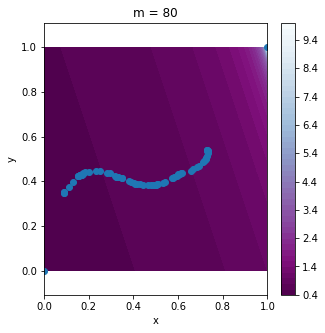

-------------Experiment for m = 80 ends!--------------


In [33]:
f_value_80, xs_80, ys_80, res_80 = bfgs(80)

-------------Experiment for m = 160 starts!--------------


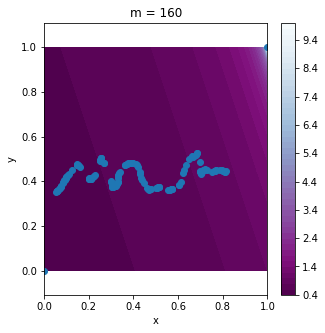

-------------Experiment for m = 160 ends!--------------


In [34]:
f_value160, xs_160, ys_160, res_160 = bfgs(160)

4. Let $f_m^*$ be the minimizing value for a given choice oof m. Plot $|f_{10}^* - f_{5}^*|, |f_{20}^* - f_{10}^*|, ..., |f_{160}^* - f_{80}^*|$ versus m = 5, 10, ...160 on a loglog plot. What do you observe

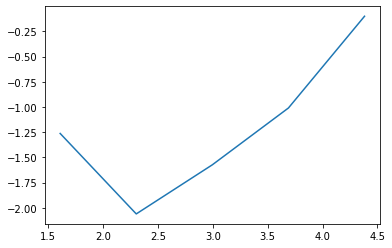

In [36]:
## BFGS trend
trend = np.array([abs(f_value_10 - f_value_5), abs(f_value_20 - f_value_10), abs(f_value_40 - f_value_20), abs(f_value_80 - f_value_40), abs(f_value160 - f_value_80)])
m = [5, 10, 20, 40, 80]
plt.plot(np.log(m), np.log(trend))

Using the gradient descent, the marginal improvement in optimized function value grows exponentially

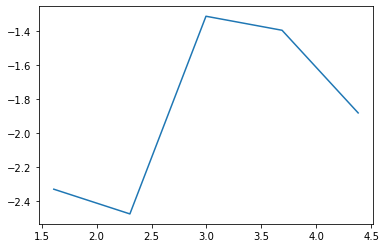

In [64]:
# gradient descent trend
trend_g= np.array([abs(fn_5_g[-1] - fn_10_g[-1]), abs(fn_20_g[-1]- fn_10_g[-1]), abs(fn_40_g[-1] - fn_20_g[-1]), abs(fn_80_g[-1] - fn_40_g[-1]), abs(fn_160_g[-1] - fn_80_g[-1])])
m = [5, 10, 20, 40, 80]
plt.plot(np.log(m), np.log(trend_g))

5. For each $m$ and for each optimization algorithm, plot the magnitude of the step size versus the iteration count on a loglog plot. What do you observe? How do the methods compare?

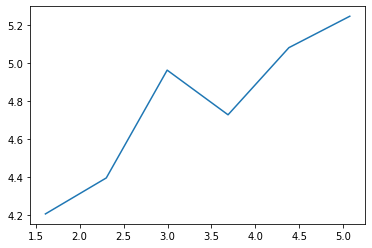

In [65]:

# gradient descent
m = [5, 10, 20, 40, 80, 160]
gd_iteration = [i_5_g, i_10_g, i_20_g, i_40_g, i_80_g, i_160_g]
plt.plot(np.log(m), np.log(gd_iteration))

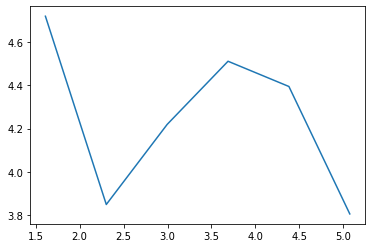

In [69]:
bfgs_iter = [res_5['nit'], res_10['nit'], res_20['nit'], res_40['nit'],res_80['nit'], res_160['nit']]
plt.plot(np.log(m), np.log(bfgs_iter))

the number of iteration till convergence grows linearly as m increases in the gradient descent algorithm. 

The number of iteration till convergence is similar as m increases in BFGS.